<a href="https://colab.research.google.com/github/Pierre-Aurelien/REBECA/blob/main/All_about_REBECA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -U keras-tuner

     |████████████████████████████████| 71kB 3.9MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=5525d9516b1cdd00d4b9564e4e8acc3cc978393f6d494adc784c962b6a4ab6c2
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=bec82cdfadff86fa9fc358b05387f34b5feb5ea7cbff027476e99c89babc6d0b
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
import pathlib
import os,datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np  
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional,LSTM,GRU,Dense,Conv2D,Flatten,MaxPooling2D
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
%config InlineBackend.figure_format = 'retina'
from google.colab import drive,files
import io
from kerastuner.tuners import BayesianOptimization

# Pre-process data

In [ ]:
#uploaded = files.upload()
#df = pd.read_csv(io.BytesIO(uploaded['Evfratov_dataset.csv']))
#drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
##Upload Evfratov dataset
uploaded = files.upload()
df=pd.read_csv("/content/drive/My Drive/Evfratov/Evfratov_dataset.csv")

In [ ]:
df['UTR']=df.apply(lambda row: row['Sequence'][:-3],axis=1) #Remove Methionine codon
df['UTR_length']=df.apply(lambda row: len(row['UTR']),axis=1)
df.head()

,Sequence,F1,F2,F3,F4,F5,F6,F7,F8,Bin mode,Precision,UTR,UTR_length
0,AAAAAAACGUGUCUGAACAACCAGUGCGAAAUG,0.0,0.0,0.0,0.000063,0.000000,0.000000,0.0,0.0,3,23,AAAAAAACGUGUCUGAACAACCAGUGCGAA,30
1,AAAAAAGAAUGUAAUCGAGAGAUAAGGGAUAUG,0.0,0.0,0.0,0.000000,0.000056,0.000000,0.0,0.0,4,25,AAAAAAGAAUGUAAUCGAGAGAUAAGGGAU,30
2,AAAAAAUACAUUAUGGUUACCUCGAACGAGAUG,0.0,0.0,0.0,0.000069,0.000000,0.000000,0.0,0.0,3,25,AAAAAAUACAUUAUGGUUACCUCGAACGAG,30
3,AAAAACAAGCGGAUGUCAUAGGAACCGUAGAUG,0.0,0.0,0.0,0.000000,0.000067,0.000000,0.0,0.0,4,30,AAAAACAAGCGGAUGUCAUAGGAACCGUAG,30
4,AAAAAGGUUUGUUAUGGUGGACCGGGAAUGAUG,0.0,0.0,0.0,0.000000,0.000000,0.000021,0.0,0.0,5,21,AAAAAGGUUUGUUAUGGUGGACCGGGAAUG,30


## Quality Check- Only keep in the test set sequences with enough reads (Precision>30)

In [ ]:
df=df[df['Precision']>=1]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28402 entries, 0 to 28401
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sequence    28402 non-null  object 
 1   F1          28402 non-null  float64
 2   F2          28402 non-null  float64
 3   F3          28402 non-null  float64
 4   F4          28402 non-null  float64
 5   F5          28402 non-null  float64
 6   F6          28402 non-null  float64
 7   F7          28402 non-null  float64
 8   F8          28402 non-null  float64
 9   Bin mode    28402 non-null  int64  
 10  Precision   28402 non-null  int64  
 11  UTR         28402 non-null  object 
 12  UTR_length  28402 non-null  int64  
dtypes: float64(8), int64(3), object(2)
memory usage: 3.0+ MB


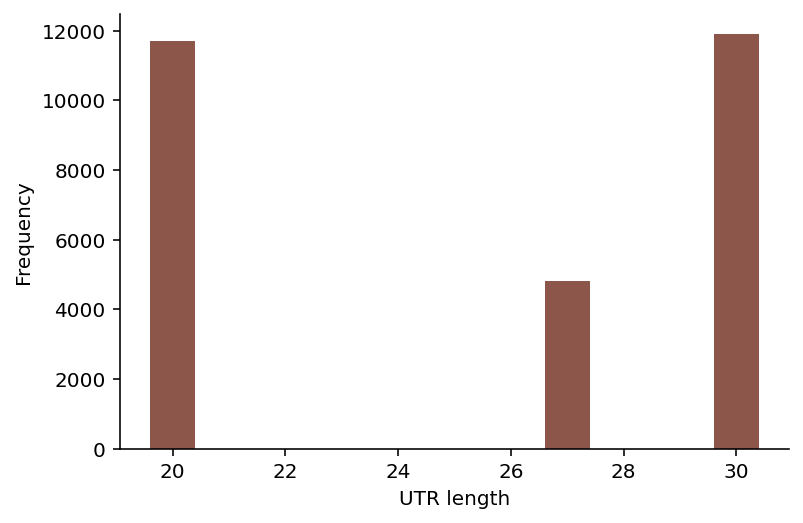

In [ ]:
UL=np.unique(df['UTR_length'], return_index=True, return_inverse=True, return_counts=True)
plt.bar(x=UL[0],height=UL[3],color='tab:brown')
plt.xlabel('UTR length'),plt.ylabel('Frequency')
sns.despine()

## Split dataset intro Training, Validation and Test sets



###Checking data imbalance

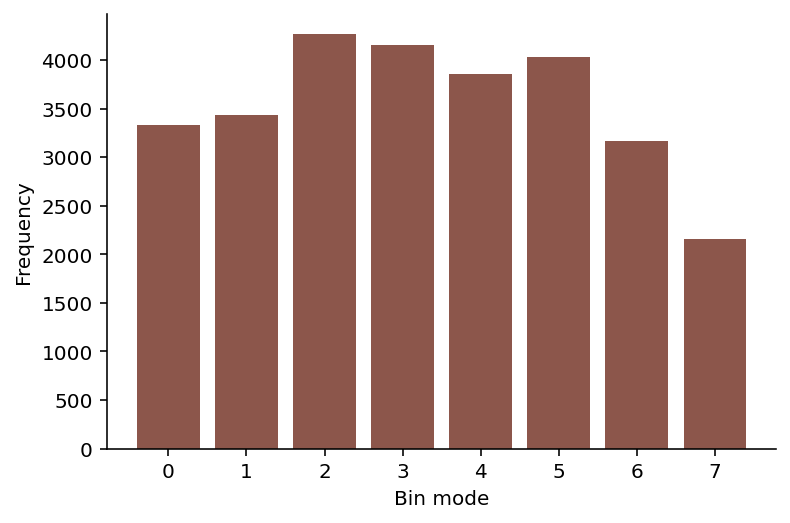

In [ ]:
DI=np.unique(df['Bin mode'], return_index=True, return_inverse=True, return_counts=True)
plt.bar(x=DI[0],height=DI[3],color='tab:brown')
plt.xlabel('Bin mode'),plt.ylabel('Frequency')
sns.despine()

In [ ]:
ID_tt=train_test_split(df[df['Precision']>=30]['UTR'], df[df['Precision']>=30]['Bin mode'],stratify=df[df['Precision']>=30]['Bin mode'], test_size=1500, random_state=11)
df_train_index,df_test_index = ID_tt[0].index, ID_tt[1].index   #Test set size: 1500 sequences
test_set,df_train=df.iloc[df_test_index,:],df.drop(df_test_index)
ID_tv=train_test_split(df_train['UTR'], df_train['Bin mode'],stratify=df_train['Bin mode'], test_size=1500, random_state=11)
df_train_index,df_val_index = ID_tv[0].index,ID_tv[1].index   #Validation set size: 1500 sequences
train_set,validation_set=df_train.drop(df_val_index),df_train.drop(df_train_index)

# Assessing the baseline by simply looking at data imbalance



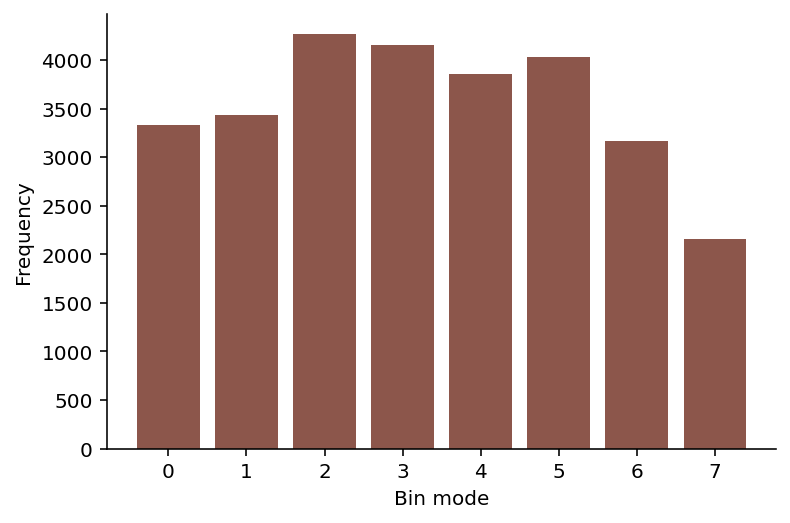

In [ ]:
DI=np.unique(df['Bin mode'], return_index=True, return_inverse=True, return_counts=True)
plt.bar(x=DI[0],height=DI[3],color='tab:brown')
plt.xlabel('Bin mode'),plt.ylabel('Frequency')
sns.despine()

Let's consider the algorithm returning bin No.2 all the time:

In [ ]:
from sklearn import metrics
# True values
y_true = test_set['Bin mode'].values
# Predicted values
y_pred =[2 for i in y_true]
metrics.confusion_matrix(y_true, y_pred)
# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))
# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[   0    0 1582    0    0    0    0    0]
 [   0    0 1576    0    0    0    0    0]
 [   0    0 1751    0    0    0    0    0]
 [   0    0 1983    0    0    0    0    0]
 [   0    0 1997    0    0    0    0    0]
 [   0    0 1831    0    0    0    0    0]
 [   0    0 1570    0    0    0    0    0]
 [   0    0 1047    0    0    0    0    0]]
              precision    recall  f1-score   support

           0      0.000     0.000     0.000      1582
           1      0.000     0.000     0.000      1576
           2      0.131     1.000     0.232      1751
           3      0.000     0.000     0.000      1983
           4      0.000     0.000     0.000      1997
           5      0.000     0.000     0.000      1831
           6      0.000     0.000     0.000      1570
           7      0.000     0.000     0.000      1047

    accuracy                          0.131     13337
   macro avg      0.016     0.125     0.029     13337
weighted avg      0.017     0.131     0.030     13337



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Exploring BiLSTM architecture


### Encoding sequences for RNN-- The expected structure has the dimensions [samples, timesteps, features]

In [ ]:
def encode(seq):
  mapping = dict(zip('ACGU', range(1,5)))
  seq2 = [mapping[i] for i in seq]
  return seq2

In [ ]:
###############TRAIN SET######################
padd=30
Nb_examples=len(train_set)
X_train = np.empty((Nb_examples, padd))
y_train=np.empty((Nb_examples))

for i in range(len(train_set)):
    Seq=train_set["UTR"].iloc[i]
    Seq_encoded=encode(Seq)
    padding_number=padd-len(Seq)
    X_train[i]=np.pad(Seq_encoded,(0,padding_number), 'constant')
    y_train[i]=train_set["Bin mode"].iloc[i]

X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)

###############VALIDATION SET######################
Nb_examples=len(validation_set)
X_val = np.empty((Nb_examples, padd))
y_val=np.empty((Nb_examples))


for i in range(len(validation_set)):
    Seq=validation_set["UTR"].iloc[i]
    Seq_encoded=encode(Seq)
    padding_number=padd-len(Seq)
    X_val[i]=np.pad(Seq_encoded, (0,padding_number), 'constant')
    y_val[i]=train_set["Bin mode"].iloc[i]

X_val=X_val.reshape(X_val.shape[0],X_val.shape[1],1)

###############TEST SET######################  
Nb_examples=len(test_set)
X_test = np.empty((Nb_examples, padd))
y_test=np.empty((Nb_examples))
for i in range(len(test_set)):
    Seq=test_set["UTR"].iloc[i]
    Seq_encoded=encode(Seq)
    padding_number=padd-len(Seq)
    X_test[i]=np.pad(Seq_encoded, (0,padding_number), 'constant')
    y_test[i]=train_set["Bin mode"].iloc[i]

X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

### Deploying LSTM

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Masking(mask_value=0.,
                                  input_shape=(30, 1)))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001,clipvalue=1.0),
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

history=model.fit(X_train, y_train,validation_data=(X_val,y_val),epochs=10,verbose=1,batch_size=32,callbacks=callback)

Epoch 1/10
794/794 [==============================] - 10s 12ms/step - loss: 2.0512 - accuracy: 0.1538 - val_loss: 2.0820 - val_accuracy: 0.1300
Epoch 2/10
794/794 [==============================] - 8s 10ms/step - loss: 2.0142 - accuracy: 0.1645 - val_loss: 2.2372 - val_accuracy: 0.0993
Epoch 3/10
794/794 [==============================] - 8s 10ms/step - loss: 2.0087 - accuracy: 0.1671 - val_loss: 2.1768 - val_accuracy: 0.1307


In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Masking(mask_value=0.,
                                  input_shape=(30, 1)))
model.add(Bidirectional(LSTM(50,return_sequences=True)))
model.add(Bidirectional(LSTM(50)))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001,clipvalue=1.0),
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

history=model.fit(X_train, y_train,validation_data=(X_val,y_val),epochs=10,verbose=1,batch_size=32,callbacks=callback)

Epoch 1/10
794/794 [==============================] - 18s 23ms/step - loss: 2.0562 - accuracy: 0.1504 - val_loss: 2.1336 - val_accuracy: 0.1627
Epoch 2/10
794/794 [==============================] - 15s 19ms/step - loss: 2.0099 - accuracy: 0.1665 - val_loss: 2.1159 - val_accuracy: 0.1700
Epoch 3/10
794/794 [==============================] - 15s 19ms/step - loss: 1.9845 - accuracy: 0.1820 - val_loss: 2.1622 - val_accuracy: 0.1467
Epoch 4/10
794/794 [==============================] - 15s 19ms/step - loss: 1.9418 - accuracy: 0.2040 - val_loss: 2.2424 - val_accuracy: 0.1340


Modeling such phenomena with LSTM only is hard

# Exploring CNN architecture

## Clean sequences+Padding+Data Augmentation

In [ ]:
# Create One-hot encode function
def one_hot_encode(seq):
    mapping = dict(zip('ACGU', range(4)))    
    seq2 = [mapping[i] for i in seq]
    return np.eye(4)[seq2]

In [ ]:
padd=30
data_augmentation=(train_set[train_set['UTR_length']==20]).count()[0]
Nb_examples=len(train_set)+10*data_augmentation
X_train = np.empty((Nb_examples, padd, 4))
y_train=np.empty((Nb_examples))
p=-1

for i in range(len(train_set)):
    p+=1
    Seq=train_set["UTR"].iloc[i]
    OHE=one_hot_encode(Seq)
    padding_number=padd-len(Seq)
    X_train[p]=np.pad(OHE, ((0,padding_number), (0, 0)), 'constant')
    y_train[p]=train_set["Bin mode"].iloc[i]
    if train_set["UTR_length"].iloc[i]==20:
        while padding_number>0 :
          p+=1
          padding_number-=1
          X_train[p]=np.pad(OHE, ((10-padding_number, padding_number), (0, 0)), 'constant')
          y_train[p]=train_set["Bin mode"].iloc[i]
  
Nb_examples=len(validation_set)
X_val = np.empty((Nb_examples, padd, 4))
y_val=np.empty((Nb_examples))

for i in range(len(validation_set)):
    Seq=validation_set["UTR"].iloc[i]
    OHE=one_hot_encode(Seq)
    padding_number=padd-len(Seq)
    X_val[i]=np.pad(OHE, ((0,padding_number), (0, 0)), 'constant')
    y_val[i]=validation_set["Bin mode"].iloc[i]

Nb_examples=len(test_set)
X_test = np.empty((Nb_examples, padd, 4))
y_test=np.empty((Nb_examples))

for i in range(len(test_set)):
    Seq=test_set["UTR"].iloc[i]
    OHE=one_hot_encode(Seq)
    padding_number=padd-len(Seq)
    X_test[i]=np.pad(OHE, ((0,padding_number), (0, 0)), 'constant')
    y_test[i]=test_set["Bin mode"].iloc[i]


In [ ]:
len(y_train),len(y_val),len(y_test)

(128752, 1500, 1500)

## Visual Representation of one-hot encoding

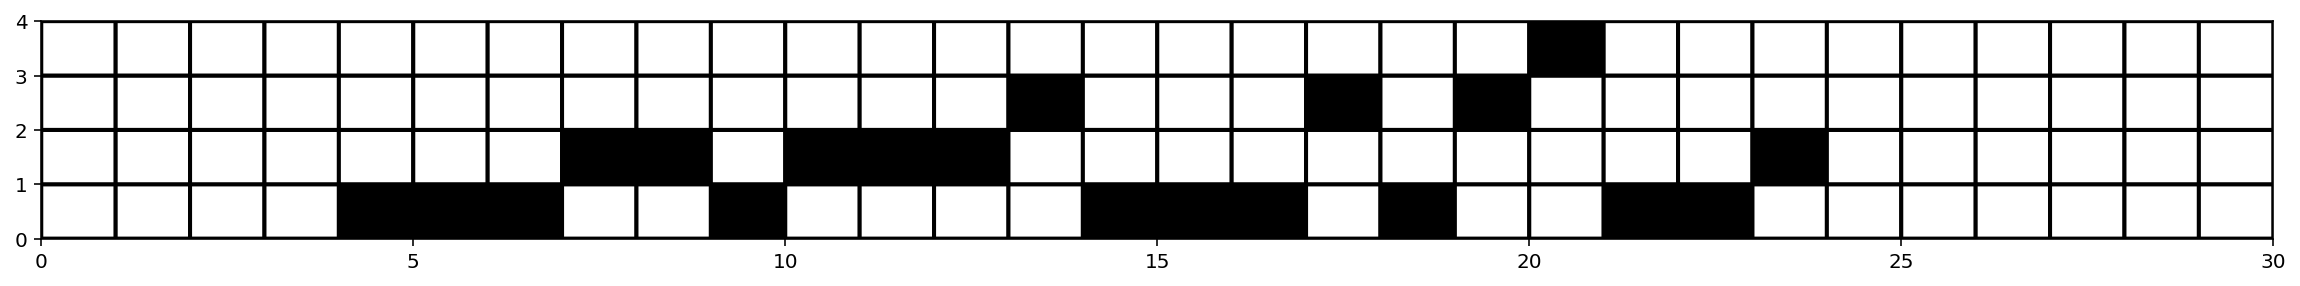

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,2))    
ax1.pcolor(np.transpose(X_train[12068]),cmap="gray_r", edgecolors='k', linewidths=2)

#Deploying Neural Network

In [ ]:
# Dealing with an imbalanced dataset
CW=1/(10*np.unique(y_train, return_index=True, return_inverse=True, return_counts=True)[3]/len(y_train))
Class_weights=dict(zip(np.arange(9),CW))

In [ ]:
Model_3=keras.models.Sequential([
             keras.layers.Conv1D(128,4,input_shape=[30,4]),
             keras.layers.Conv1D(64,8),
             keras.layers.MaxPool1D(2),
             keras.layers.Flatten(),
             keras.layers.Dense(100,activation='relu'),
             keras.layers.Dropout(0.1),
             keras.layers.Dense(8, activation='softmax')
])

In [ ]:
Model_3.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001),metrics=["accuracy"])


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

history=Model_3.fit(X_train, y_train,validation_data=(X_val,y_val),epochs=8,verbose=1,batch_size=32,callbacks=callback)

Epoch 1/8
4074/4074 [==============================] - 11s 3ms/step - loss: 1.3795 - accuracy: 0.4336 - val_loss: 1.5439 - val_accuracy: 0.3873
Epoch 2/8
4074/4074 [==============================] - 11s 3ms/step - loss: 1.3597 - accuracy: 0.4416 - val_loss: 1.5429 - val_accuracy: 0.3740
Epoch 3/8
4074/4074 [==============================] - 11s 3ms/step - loss: 1.3416 - accuracy: 0.4484 - val_loss: 1.5458 - val_accuracy: 0.3800
Epoch 4/8
4074/4074 [==============================] - 11s 3ms/step - loss: 1.3258 - accuracy: 0.4532 - val_loss: 1.5646 - val_accuracy: 0.3687


##Exploring DNN

In [ ]:
Model_d=keras.models.Sequential([
             keras.layers.Flatten(input_shape=(30, 4)),
             keras.layers.Dense(100,activation='relu'),
             keras.layers.Dense(100,activation='relu'),
             keras.layers.Dense(8, activation='softmax')
])

Model_d.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001),metrics=["accuracy"])


callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

history=Model_d.fit(X_train, y_train,validation_data=(X_val,y_val),epochs=20,verbose=2,batch_size=32,callbacks=callback)

Epoch 1/20
4074/4074 - 7s - loss: 1.6215 - accuracy: 0.3272 - val_loss: 1.6200 - val_accuracy: 0.3360
Epoch 2/20
4074/4074 - 7s - loss: 1.4898 - accuracy: 0.3809 - val_loss: 1.5637 - val_accuracy: 0.3607
Epoch 3/20
4074/4074 - 7s - loss: 1.4361 - accuracy: 0.4051 - val_loss: 1.5572 - val_accuracy: 0.3467
Epoch 4/20
4074/4074 - 7s - loss: 1.3988 - accuracy: 0.4206 - val_loss: 1.5509 - val_accuracy: 0.3533
Epoch 5/20
4074/4074 - 7s - loss: 1.3717 - accuracy: 0.4317 - val_loss: 1.5483 - val_accuracy: 0.3673
Epoch 6/20
4074/4074 - 8s - loss: 1.3486 - accuracy: 0.4437 - val_loss: 1.5379 - val_accuracy: 0.3847
Epoch 7/20
4074/4074 - 7s - loss: 1.3303 - accuracy: 0.4517 - val_loss: 1.5327 - val_accuracy: 0.3607
Epoch 8/20
4074/4074 - 7s - loss: 1.3137 - accuracy: 0.4594 - val_loss: 1.5594 - val_accuracy: 0.3720
Epoch 9/20
4074/4074 - 7s - loss: 1.3004 - accuracy: 0.4643 - val_loss: 1.5347 - val_accuracy: 0.3687


#Exploring CNN and LSTM

In [ ]:
Model_4=keras.models.Sequential([
             keras.layers.Conv1D(128,4,input_shape=[30,4]),
             keras.layers.Conv1D(64,8),
             keras.layers.MaxPool1D(2),
             keras.layers.GRU(50,dropout=0.1,recurrent_dropout=0.3),
            #  keras.layers.Bidirectional(keras.layers.LSTM(50,dropout=0.1,recurrent_dropout=0.5)),
             keras.layers.Dense(8, activation='softmax')
])

In [ ]:
Model_4.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001),metrics=["accuracy"])


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

history=Model_4.fit(X_train, y_train,validation_data=(X_val,y_val),epochs=12,verbose=1,batch_size=32,callbacks=callback)

Epoch 1/12
4223/4223 [==============================] - 172s 41ms/step - loss: 1.4609 - accuracy: 0.3955 - val_loss: 1.5824 - val_accuracy: 0.3570
Epoch 2/12
4223/4223 [==============================] - 170s 40ms/step - loss: 1.3239 - accuracy: 0.4572 - val_loss: 1.5558 - val_accuracy: 0.3530
Epoch 3/12
4223/4223 [==============================] - 172s 41ms/step - loss: 1.2742 - accuracy: 0.4794 - val_loss: 1.5391 - val_accuracy: 0.3920
Epoch 4/12
4223/4223 [==============================] - 168s 40ms/step - loss: 1.2426 - accuracy: 0.4960 - val_loss: 1.5463 - val_accuracy: 0.3900
Epoch 5/12
4223/4223 [==============================] - 165s 39ms/step - loss: 1.2227 - accuracy: 0.5049 - val_loss: 1.5730 - val_accuracy: 0.3720


#Final model-Rebeca

In [ ]:
Rebeca=keras.models.Sequential([
             keras.layers.Conv1D(128,4,input_shape=[30,4],kernel_initializer='GlorotNormal'),
             keras.layers.Conv1D(64,8,kernel_initializer='GlorotNormal'),
             keras.layers.MaxPool1D(2),
             keras.layers.Bidirectional(keras.layers.LSTM(100,dropout=0.3)),
             keras.layers.Dense(8, activation='softmax',kernel_initializer='GlorotNormal')
])


In [ ]:
Rebeca.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 27, 128)           2176      
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 20, 64)            65600     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 200)               132000    
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1608      
Total params: 201,384
Trainable params: 201,384
Non-trainable params: 0
_________________________________________________________________


In [ ]:
initial_learning_rate = 1e-3
decay_steps = 1.0
decay_rate = 0.5
learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate, decay_steps, decay_rate)

In [ ]:
Rebeca.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(
                  learning_rate=learning_rate_fn,clipvalue=1.0),
                  metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

history=Rebeca.fit(X_train, y_train,validation_data=(X_val,y_val),epochs=17,verbose=1,batch_size=32,callbacks=callback)

Epoch 1/17
4223/4223 [==============================] - 28s 7ms/step - loss: 1.9007 - accuracy: 0.2407 - val_loss: 2.0668 - val_accuracy: 0.1780
Epoch 2/17
3214/4223 [=====================>........] - ETA: 6s - loss: 1.8790 - accuracy: 0.2474

KeyboardInterrupt: ignored

# Load REBECA

In [ ]:
keras.backend.clear_session()
# Recreate the exact same model, including its weights and the optimizer
new_model = keras.models.load_model('/content/drive/My Drive/REBECA/Rebeca.h5')
#model = keras.models.load_model('path/to/location')
# Show the model architecture
new_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 27, 128)           2176      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 20, 64)            65600     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100)               46000     
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 808       
Total params: 114,584
Trainable params: 114,584
Non-trainable params: 0
_________________________________________________________________


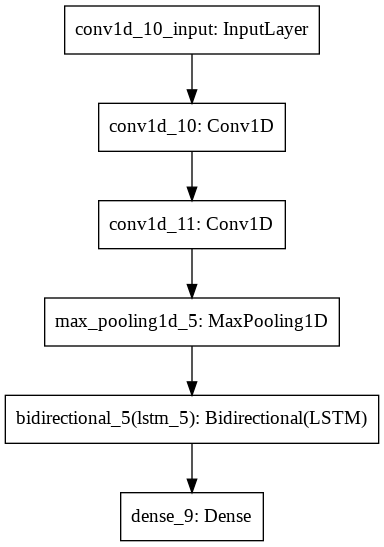

In [ ]:
keras.utils.plot_model(new_model)

In [ ]:
from sklearn import metrics
# True values
y_true = test_set['Bin mode'].values
# Predicted values
y_pred =[i.argmax() for i in new_model.predict(X_test)]

metrics.confusion_matrix(y_true, y_pred)
# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))
# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[122  16  10   5   1   3   5   2]
 [ 33 108  25  10   6   0   0   0]
 [ 18  26 135  38  10  13   3   2]
 [  8   8  37 102  27  13   5   1]
 [  3   1  18  18  89  29  10   5]
 [  0   2   2  13  13 147  33   9]
 [  1   2   1   1   6  26 105  40]
 [  1   1   0   1   1   4  19 107]]
              precision    recall  f1-score   support

           0      0.656     0.744     0.697       164
           1      0.659     0.593     0.624       182
           2      0.592     0.551     0.571       245
           3      0.543     0.507     0.524       201
           4      0.582     0.514     0.546       173
           5      0.626     0.671     0.648       219
           6      0.583     0.577     0.580       182
           7      0.645     0.799     0.713       134

    accuracy                          0.610      1500
   macro avg      0.611     0.620     0.613      1500
weighted avg      0.608     0.610     0.607      1500



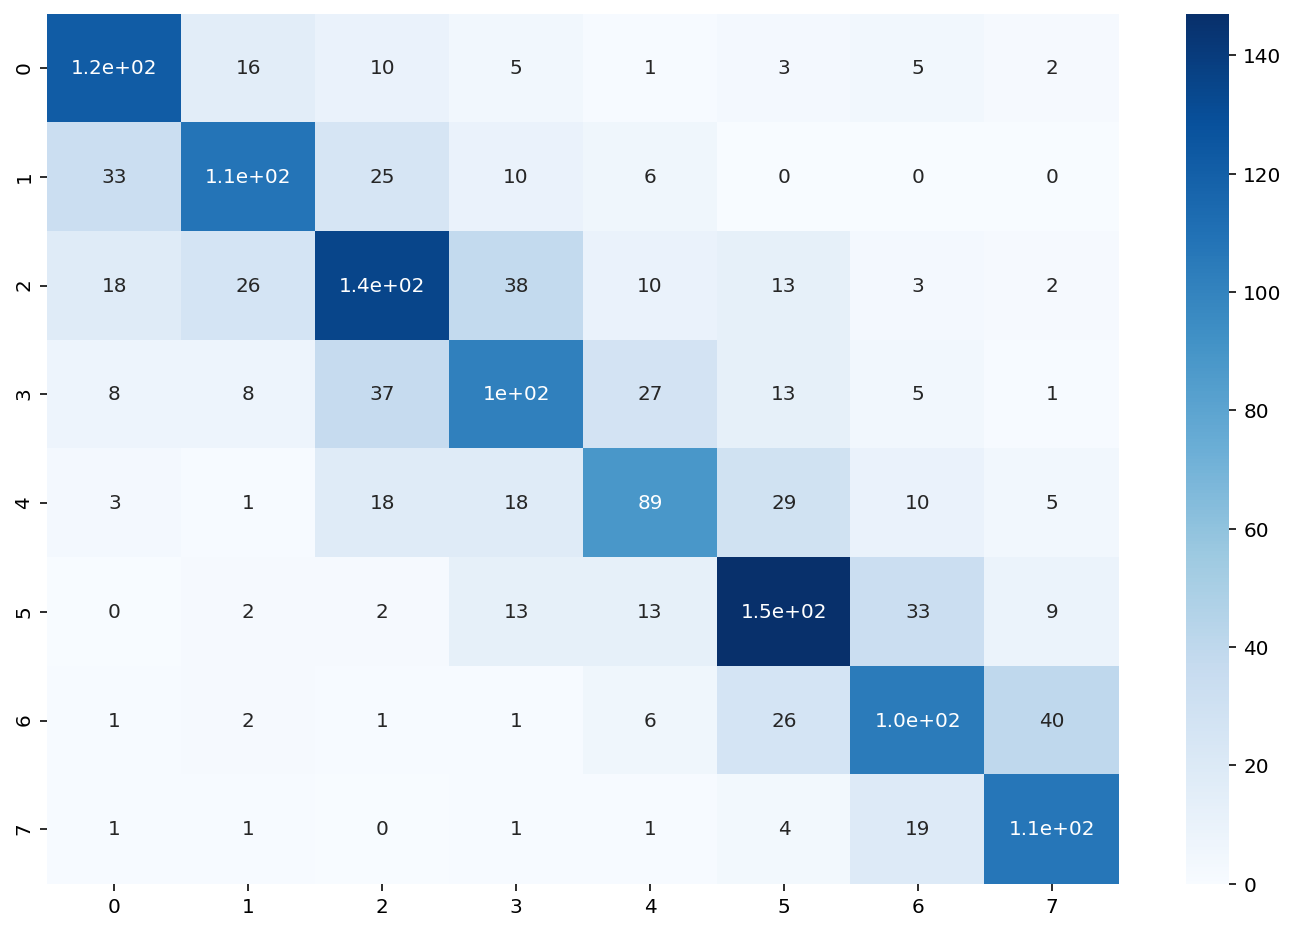

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
cm=metrics.confusion_matrix(y_true, y_pred)
#cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis])
#cm=cm.astype('float') /len(y_test)
#cm[cm < 2] = 0
ax = sns.heatmap(cm, cmap="Blues",annot=True)

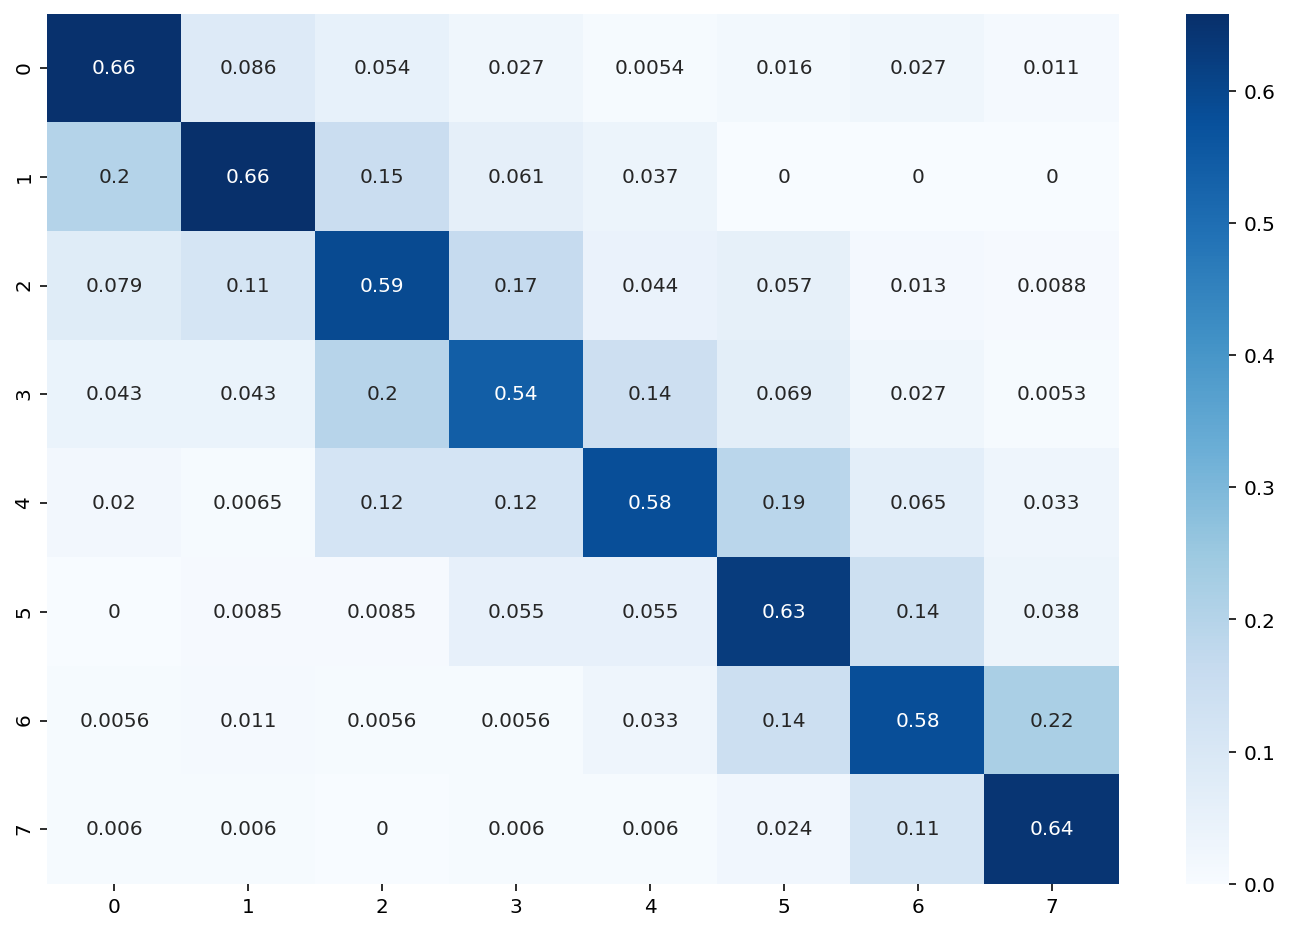

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
cm=metrics.confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / (cm.sum(axis=0)[:, np.newaxis])
#cm=cm.astype('float') /len(y_test)
#cm[cm < 2] = 0
ax = sns.heatmap(cm, cmap="Blues",annot=True)

In [ ]:
(cm.sum(axis=0)[:, np.newaxis])

array([[186],
       [164],
       [228],
       [188],
       [153],
       [235],
       [180],
       [166]])

In [ ]:
Kuo=pd.read_csv("/content/drive/My Drive/Kuo/Kuo_partial.csv")
Kuo['RBS']=Kuo['RBS'].str[3:]+'AUG'

Kuo['Mean']=pd.to_numeric(Kuo['Mean'], downcast="float")
def stratify_fluorescence(x):
  return(np.floor(8*x/(max(Kuo['Mean'])-min(Kuo['Mean']))))

Kuo['Bin_proxy']=stratify_fluorescence(Kuo['Mean'])
#Kuo['Bin_proxy']=Kuo.apply(lambda row: stratify_fluorescence(row['Mean']),axis=1)
Kuo.head()

,RBS,Mean,Context,max_value,min_value,Bin_proxy
0,ACCUUAUUAAUAAAAAAAAGGUGAUUUAUG,2.683,1,3.292754,2.073247,7.0
1,ACCUUAUUAAUAAAAAAACACUGAUUUAUG,1.252,1,1.891021,0.612979,3.0
2,ACCUUAUUAAUAAAAAAACAGUGAUUUAUG,0.950,1,1.754119,0.145881,2.0
3,ACCUUAUUAAUAAAAAAACCAUGAUUUAUG,1.120,1,1.461544,0.778456,3.0
4,ACCUUAUUAAUAAAAAAACCGUGAUUUAUG,1.201,1,2.182978,0.219022,3.0


## Prepare Data

In [ ]:
#Subsample Kuo:
Kuo=Kuo.loc[Kuo['Context']==2].sample(n=50000, random_state=32)
#Kuo=Kuo.groupby("Bin_proxy").sample(n=10000, random_state=32)
Kuo=Kuo[Kuo['Mean'] < Kuo['Mean'].quantile(.95)]
Kuo=Kuo[Kuo['Mean'] > Kuo['Mean'].quantile(.05)]
#Test set
ID_tt=train_test_split(Kuo['RBS'], Kuo['Mean'],stratify=Kuo['Bin_proxy'], test_size=9500, random_state=32)
df_train_index,df_test_index = ID_tt[0].index, ID_tt[1].index   #Test set size: 15 000 sequences
test_dataset,df_train=Kuo.drop(df_train_index),Kuo.drop(df_test_index)
#Train and validation set
ID_tv=train_test_split(df_train['RBS'], df_train['Mean'],stratify=df_train['Bin_proxy'], test_size=100, random_state=32)
df_train_index,df_val_index = ID_tv[0].index,ID_tv[1].index   #Validation set size: 3 000 sequences, Transfer learning set:27 000
df_train,df_val=df_train.drop(df_val_index),df_train.drop(df_train_index)
df_train.tail(),df_val.head(),test_dataset.head()

(                                   RBS   Mean  ...  min_value  Bin_proxy
 288385  GUUUCUAGAACCUUGGCGUCCGUAAGAAUG  0.413  ...   0.173507        1.0
 242137  GUUUCUAGAACCUGUAAUCUGGUAAGAAUG  0.595  ...   0.234496        1.0
 276350  GUUUCUAGAACCUUCGUAUUAGUAAGAAUG  0.503  ...   0.319558        1.0
 236689  GUUUCUAGAACCUGGCUUUCGUUAAGAAUG  0.433  ...   0.297468        1.0
 274591  GUUUCUAGAACCUUCGACUUCGUAAGAAUG  0.374  ...   0.183168        1.0
 
 [5 rows x 6 columns],
                                    RBS   Mean  ...  min_value  Bin_proxy
 130088  GUUUCUAGAACCUACGCGCUUGUAAGAAUG  0.520  ...   0.164296        1.0
 215393  GUUUCUAGAACCUGAGGGGCACUAAGAAUG  0.537  ...   0.077526        1.0
 252200  GUUUCUAGAACCUGUUGAAUUGUAAGAAUG  0.824  ...   0.501806        2.0
 196184  GUUUCUAGAACCUCUAGCGUAGUAAGAAUG  0.504  ...   0.062823        1.0
 117288  GUUUCUAGAACCUAAGAUCUCGUAAGAAUG  0.556  ...   0.177366        1.0
 
 [5 rows x 6 columns],
                                    RBS   Mean  ...  min_value

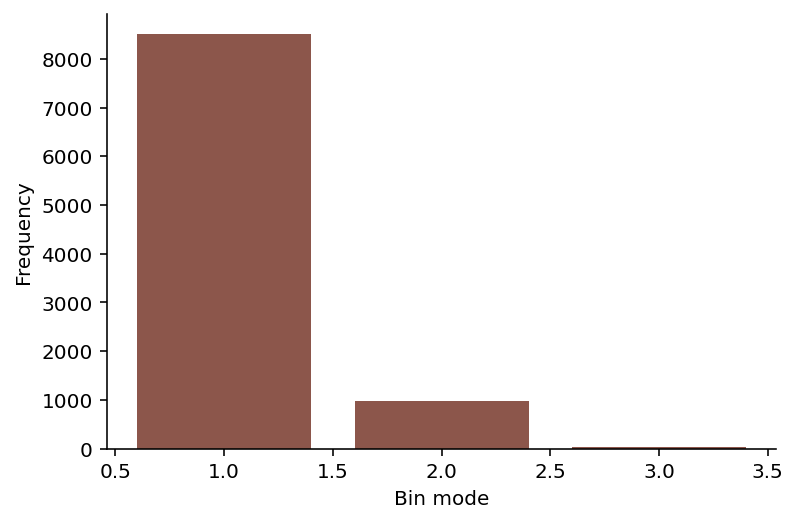

In [ ]:
DI=np.unique(test_dataset['Bin_proxy'], return_index=True, return_inverse=True, return_counts=True)
plt.bar(x=DI[0],height=DI[3],color='tab:brown')
plt.xlabel('Bin mode'),plt.ylabel('Frequency')
sns.despine()

In [ ]:
# Create One-hot encode function
def one_hot_encode(seq):
    mapping = dict(zip('ACGU', range(4)))    
    seq2 = [mapping[i] for i in seq]
    return np.eye(4)[seq2]


padd=30
Nb_examples=len(df_train)
X_train = np.zeros((Nb_examples, padd, 4))
y_train=np.zeros((Nb_examples))

for i in range(Nb_examples):
    Seq=df_train["RBS"].iloc[i]
    OHE=one_hot_encode(Seq)
    padding_number=padd-len(Seq)
    X_train[i]=OHE
    y_train[i]=df_train["Mean"].iloc[i]

  
Nb_examples=len(df_val)
X_val = np.zeros((Nb_examples, padd, 4))
y_val=np.zeros((Nb_examples))

for i in range(Nb_examples):
    Seq=df_val["RBS"].iloc[i]
    OHE=one_hot_encode(Seq)
    padding_number=padd-len(Seq)
    X_val[i]=OHE
    y_val[i]=df_val["Mean"].iloc[i]

Nb_examples=len(test_dataset)
X_test = np.empty((Nb_examples, padd, 4))
y_test=np.empty((Nb_examples))

for i in range(len(test_dataset)):
    Seq=test_dataset["RBS"].iloc[i]
    OHE=one_hot_encode(Seq)
    padding_number=padd-len(Seq)
    X_test[i]=OHE
    y_test[i]=test_dataset["Mean"].iloc[i]

len(X_train),len(X_val),len(X_test)

(35470, 100, 9500)

## Remove last layer

In [ ]:
REBECA = keras.Sequential()
for layer in new_model.layers[:-1]: # go through until last layer
    REBECA.add(layer)
#REBECA.add(keras.layers.Dense(1, activation='linear'))
REBECA.summary()
#model.compile(optimizer='adam', loss='categorical_crossentropy')



#inputs = keras.Input(shape=(30,4,1))
#predictions = keras.layers.Dense(3, activation='linear')(new_model.layers[-2].output)
#REBECA = keras.Model(inputs=inputs, outputs=predictions)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 27, 128)           2176      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 20, 64)            65600     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100)               46000     
Total params: 113,776
Trainable params: 0
Non-trainable params: 113,776
_________________________________________________________________


In [ ]:
REBECA.predict(X_train[4:5])

array([[ 4.30639694e-03,  5.92218130e-05, -1.35187864e-01,
        -2.52600573e-02,  2.23476350e-01,  7.05523670e-01,
         1.41817614e-01, -5.89446306e-01, -2.45939977e-02,
        -9.98378992e-01, -4.31805044e-01, -3.57736982e-02,
         9.31980848e-01,  4.63161588e-01, -7.29784518e-02,
         1.80663131e-02, -3.32774110e-02, -9.05726492e-01,
        -6.87872112e-01, -8.81102860e-01, -2.52487361e-01,
        -4.36601400e-01, -3.28712660e-04,  1.21633396e-01,
         1.41173139e-01,  5.55362225e-01,  5.17160237e-01,
        -1.50572002e-01,  4.17598218e-01, -3.00753061e-02,
         5.51514506e-01,  6.50970191e-02,  2.40033641e-02,
         1.05730772e-01,  9.26931679e-01, -3.26120667e-02,
         2.77063996e-01,  8.22317880e-03, -5.67863695e-02,
         1.36203498e-05, -7.71769881e-01,  4.69800197e-02,
         4.96696711e-01,  1.38528021e-05, -1.33256670e-02,
         8.80732108e-03, -5.06067812e-01, -3.41998623e-03,
         2.55776763e-01,  1.32000860e-05,  1.10218190e-0

##Freeze feature extraction layers- add dense layer to do regression

In [ ]:
max(y_train)

1.0950000286102295

In [ ]:
REBECA.trainable = False

inputs = keras.Input(shape=(30, 4))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = REBECA(inputs, training=False)
# A Dense classifier with a single unit (binary classification)
#x=keras.layers.Dropout(.2)(x)
outputs=max(y_train)*keras.layers.Dense(1,activation='relu')(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 30, 4)]           0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 100)               113776    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
_________________________________________________________________
tf_op_layer_Mul_2 (TensorFlo [(None, 1)]               0         
Total params: 113,877
Trainable params: 101
Non-trainable params: 113,776
_________________________________________________________________


In [ ]:
y_train

array([0.43700001, 0.62800002, 0.47400001, ..., 0.50300002, 0.433     ,
       0.37400001])

In [ ]:
# initial_learning_rate = 1e-4
# decay_steps = 50.0
# decay_rate = 0.5
# learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate, decay_steps, decay_rate)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='MSE',
              metrics=['MSE'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

history=model.fit(X_train, y_train,validation_data=(X_val,y_val),epochs=50,verbose=1,batch_size=64,callbacks=callback)

Epoch 1/50
555/555 [==============================] - 2s 4ms/step - loss: 0.0298 - MSE: 0.0298 - val_loss: 0.0211 - val_MSE: 0.0211
Epoch 2/50
555/555 [==============================] - 2s 3ms/step - loss: 0.0178 - MSE: 0.0178 - val_loss: 0.0179 - val_MSE: 0.0179
Epoch 3/50
555/555 [==============================] - 2s 3ms/step - loss: 0.0163 - MSE: 0.0163 - val_loss: 0.0169 - val_MSE: 0.0169
Epoch 4/50
555/555 [==============================] - 2s 3ms/step - loss: 0.0156 - MSE: 0.0156 - val_loss: 0.0163 - val_MSE: 0.0163
Epoch 5/50
555/555 [==============================] - 2s 3ms/step - loss: 0.0154 - MSE: 0.0154 - val_loss: 0.0164 - val_MSE: 0.0164


In [ ]:
model.predict(X_test[:8])

array([[0.6227778 ],
       [0.49925622],
       [0.48861378],
       [0.5494147 ],
       [0.4934044 ],
       [0.54619986],
       [0.4861703 ],
       [0.47006202]], dtype=float32)

In [ ]:
y_pred=model.predict(X_test)
test_dataset['Prediction']=y_pred

In [ ]:
test_dataset['Prediction']=y_pred
test_dataset['std']=(test_dataset['max_value']-test_dataset['Mean'])/3
test_dataset['SE']=(test_dataset['Prediction']-test_dataset['Mean'])**2
test_dataset['within_std']=test_dataset.apply(lambda row: 1 if np.abs(row['Prediction']-row['Mean'])<=row['std'] else 0, axis=1)
test_dataset['within_2std']=test_dataset.apply(lambda row: 1 if np.abs(row['Prediction']-row['Mean'])<=2*row['std'] else 0, axis=1)
test_dataset['within_3std']=test_dataset.apply(lambda row: 1 if np.abs(row['Prediction']-row['Mean'])<=3*row['std'] else 0, axis=1)
test_dataset['within_4std']=test_dataset.apply(lambda row: 1 if np.abs(row['Prediction']-row['Mean'])<=4*row['std'] else 0, axis=1)
test_dataset.head()

,RBS,Mean,Context,max_value,min_value,Bin_proxy,Prediction,std,SE,within_std,within_2std,within_3std,within_4std
111225,GUUUCUAGAACCUAAACUCGAUUAAGAAUG,0.475,2,0.748384,0.201616,1.0,0.622778,0.091128,0.021838,0,1,1,1
147788,GUUUCUAGAACCUAUAGCCACAUAAGAAUG,0.774,2,0.887248,0.660752,2.0,0.499256,0.037749,0.075484,0,0,0,0
167432,GUUUCUAGAACCUCAGGAUCCUUAAGAAUG,0.671,2,1.360237,-0.018237,1.0,0.488614,0.229745,0.033265,1,1,1,1
225633,GUUUCUAGAACCUGCGAAUACGUAAGAAUG,0.577,2,0.869850,0.284150,1.0,0.549415,0.097617,0.000761,1,1,1,1
251499,GUUUCUAGAACCUGUUCAUCCCUAAGAAUG,0.447,2,0.770541,0.123459,1.0,0.493404,0.107847,0.002153,1,1,1,1


In [ ]:
#Metrics
RMSE=np.sqrt(test_dataset['SE'].mean())
Within_1_std=test_dataset['within_std'].mean()
Within_2_std=test_dataset['within_2std'].mean()
Within_3_std=test_dataset['within_3std'].mean()
Within_4_std=test_dataset['within_4std'].mean()
print(RMSE,Within_1_std,Within_2_std,Within_3_std,Within_4_std)

0.12178747216070382 0.6751578947368421 0.8546315789473684 0.9209473684210526 0.9542105263157895


In [ ]:
#Metrics
RMSE=np.sqrt(test_dataset['SE'].mean())
Within_1_std=test_dataset['within_std'].mean()
Within_2_std=test_dataset['within_2std'].mean()
Within_3_std=test_dataset['within_3std'].mean()
Within_4_std=test_dataset['within_4std'].mean()
print(RMSE,Within_1_std,Within_2_std,Within_3_std,Within_4_std)

0.2809727017007335 0.5128421052631579 0.743578947368421 0.8488421052631578 0.8988421052631579


In [ ]:
test_dataset.head(30)

,RBS,Mean,Context,max_value,min_value,Bin_proxy,Prediction,std,SE,within_std,within_2std,within_3std,within_4std
94085,ACCUUAUUAAUAUCCUGACACUGAUUUAUG,0.730,1,1.138940,0.321060,2.0,0.815240,0.136313,0.007266,1,1,1,1
76930,ACCUUAUUAAUAGGACGUAAAUGAUUUAUG,0.608,1,1.018013,0.197987,1.0,1.355242,0.136671,0.558370,0,0,0,0
53990,ACCUUAUUAAUACGGCUCCCUUGAUUUAUG,0.603,1,1.251793,-0.045793,1.0,0.717463,0.216264,0.013102,1,1,1,1
86506,ACCUUAUUAAUAUACUCUGUAUGAUUUAUG,1.221,1,1.617095,0.824905,3.0,0.998294,0.132032,0.049598,0,1,1,1
93054,ACCUUAUUAAUAUCCCUACCAUGAUUUAUG,0.503,1,0.919561,0.086439,1.0,0.596968,0.138854,0.008830,1,1,1,1
5001,ACCUUAUUAAUAAAGCGAUUGUGAUUUAUG,1.921,1,2.148921,1.693079,5.0,1.419666,0.075974,0.251336,0,0,0,0
60705,ACCUUAUUAAUACUGAACAAGUGAUUUAUG,1.067,1,1.383511,0.750489,3.0,1.171910,0.105504,0.011006,1,1,1,1
76920,ACCUUAUUAAUAGGACGCUCUUGAUUUAUG,1.649,1,4.426697,-1.128697,4.0,1.444322,0.925899,0.041893,1,1,1,1
17033,ACCUUAUUAAUAAGACAUGCAUGAUUUAUG,0.697,1,0.883491,0.510509,1.0,1.088796,0.062164,0.153504,0,0,0,0
32105,ACCUUAUUAAUACACCUCGAGUGAUUUAUG,0.707,1,0.849313,0.564687,1.0,0.647398,0.047438,0.003552,0,1,1,1


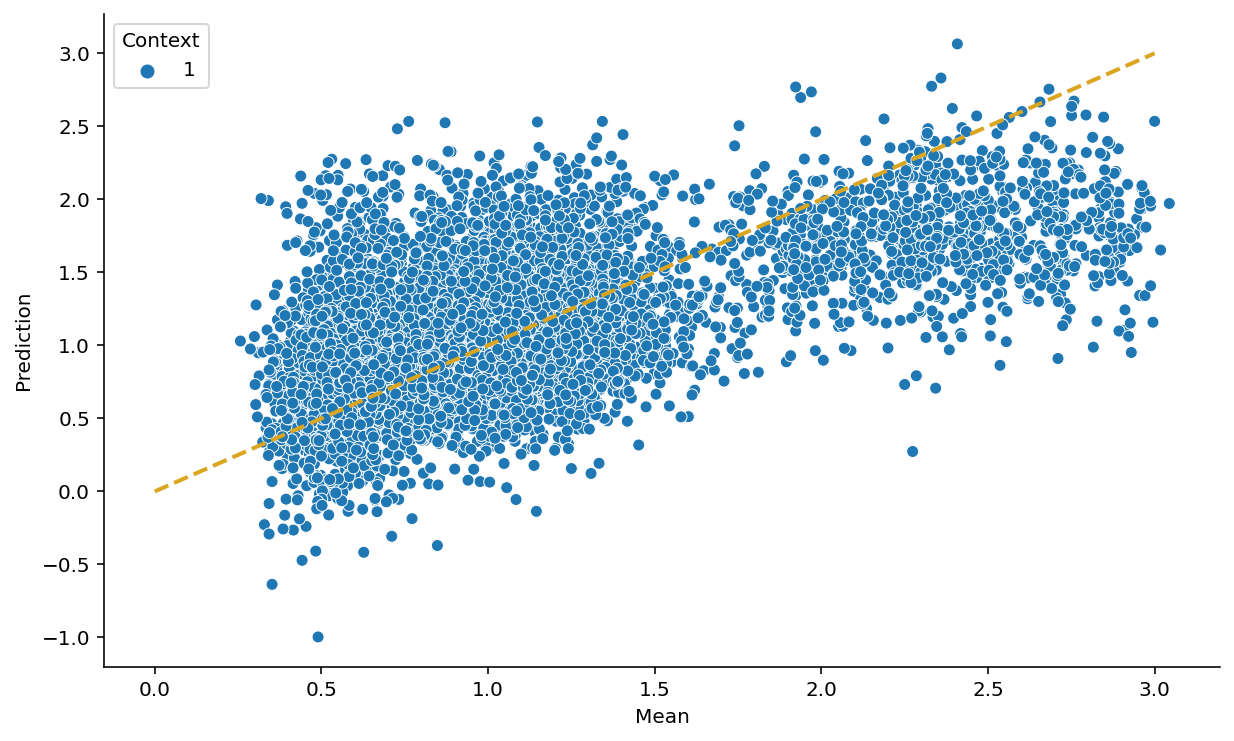

In [ ]:
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 6))
ax=sns.scatterplot(x='Mean',y='Prediction',hue='Context',data=test_dataset)
plt.plot([0,3], [0,3], color='red', marker='o', linestyle='dashed',linewidth=2, markersize=12)
sns.despine()

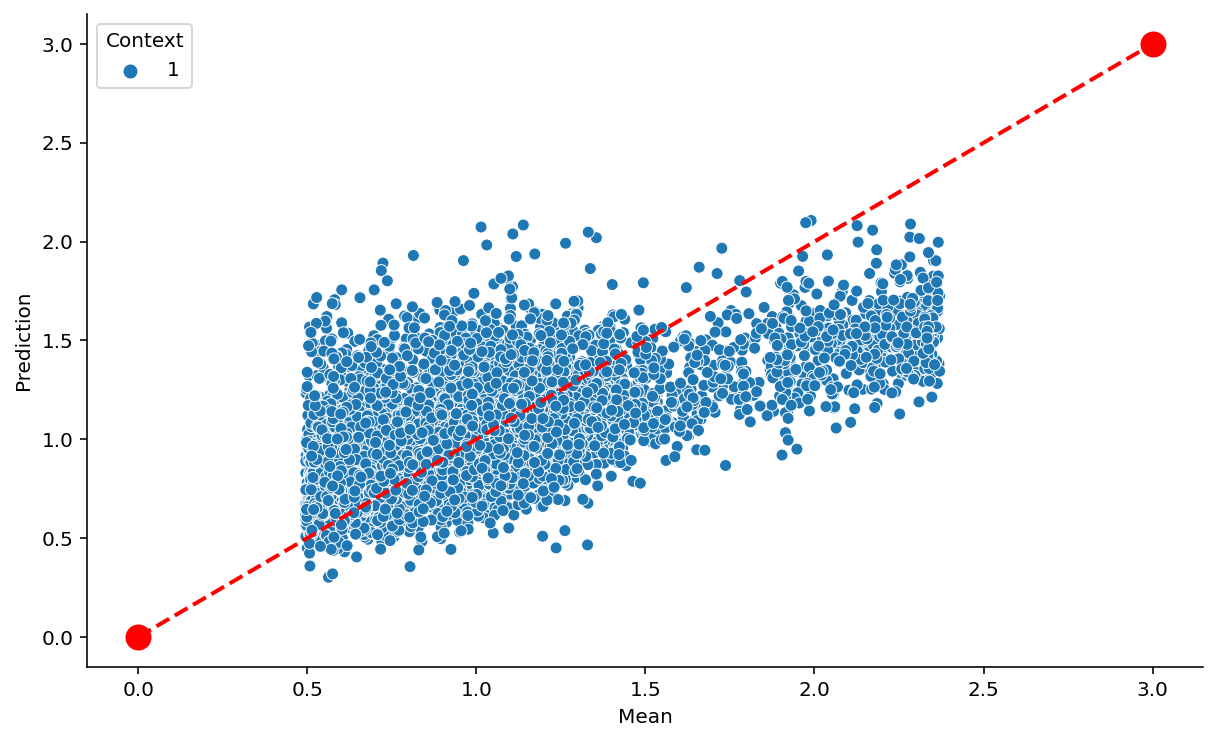

In [ ]:
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 6))
ax=sns.scatterplot(x='Mean',y='Prediction',hue='Context',data=test_dataset)
plt.plot([0,3], [0,3], color='red', marker='o', linestyle='dashed',linewidth=2, markersize=12)
sns.despine()

In [ ]:
test_dataset.to_csv('test_dataset_dmsc.csv')
files.download('test_dataset_dmsc.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

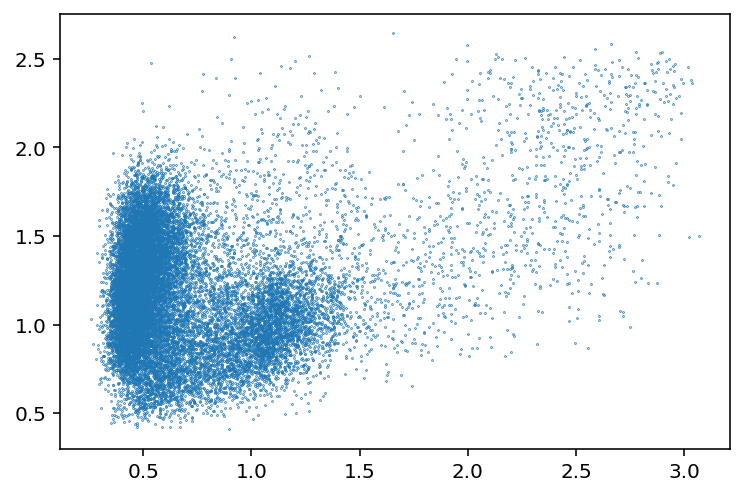

In [ ]:
plt.scatter(y_test, y_pred, s=0.1)
#plt.xlim(0,6)
#plt.ylim(0,6)

In [ ]:
y_pred

array([[0.02362873],
       [0.02362873],
       [0.02362873],
       ...,
       [0.02362873],
       [0.02362873],
       [0.02362873]], dtype=float32)

In [ ]:
np.save('result_ft.npy',y_pred)
files.download('result_ft.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
np.save('y_test.npy',y_test)
files.download('y_test.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# CNN on base pair data

In [ ]:
X=np.load("/content/drive/My Drive/Evfratov/X_UTR.npy")
y=np.load("/content/drive/My Drive/Evfratov/y_UTR.npy")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1500, random_state=32)
X_train.shape

(26902, 33, 33)

In [ ]:
X_train[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
X_train=X_train.reshape(26902,33,33,1)
X_train.shape

(26902, 33, 33, 1)

In [ ]:
# Model_BP=keras.models.Sequential([
#              keras.layers.Conv2D(128,(4,4),input_shape=(33,33,1),
#                padding='same'),
#              keras.layers.Conv2D(64,(4,4)),
#              keras.layers.MaxPool2D(2),
#              keras.layers.Flatten(),
#              keras.layers.Dense(100,activation='relu'),
#              keras.layers.Dense(8, activation='softmax')
# ])
model = keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(4, 4), activation='relu', input_shape=(33,33,1)))
model.add(MaxPooling2D(2))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='softmax'))

model.summary()
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001),metrics=["accuracy"])


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

history=model.fit(X_train, y_train,validation_split=0.06,epochs=20,verbose=1,batch_size=32,callbacks=callback)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 30, 30, 32)        544       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 2304)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)               295040    
_________________________________________________________________
dense_36 (Dense)             (None, 8)               

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv1D(filters=hp.Int('units_Conv_1',
                                        min_value=32,
                                        max_value=256,
                                        step=32),
                            kernel_size=hp.Int('kernel_size_1',
                                        min_value=2,
                                        max_value=6,
                                        step=2),
                            input_shape=[30,4],
                            activation='relu'))
    # model.add(layers.Conv1D(filters=hp.Int('units_Conv_2',
    #                                     min_value=32,
    #                                     max_value=256,
    #                                     step=32),
    #                         kernel_size=hp.Int('kernel_size_2',
    #                                     min_value=2,
    #                                     max_value=6,
    #                                     step=2),
    #                         activation='relu'))
                            
    for i in range(hp.Int('n_layers',min_value=1,max_value=3,step=1)):
      model.add(layers.Conv1D(filters=hp.Int(f'sup_conv_{i}',
                                        min_value=32,
                                        max_value=256,
                                        step=32),
                            kernel_size=hp.Int(f'sup_kernel_{i}',
                                        min_value=2,
                                        max_value=6,
                                        step=2),
                            input_shape=[30,4],
                            activation='relu'))
    model.add(layers.MaxPool1D(hp.Int('maxpooling_1',min_value=2,max_value=4,step=2)))
      

    model.add(layers.Bidirectional(keras.layers.LSTM(hp.Int('units_LSTM',
                                        min_value=50,
                                        max_value=200,
                                        step=50),dropout=hp.Choice('dropout_LSTM',
                                        values=[0.0,0.1,0.2,0.3,0.4]))))
     

    model.add(layers.Dense(8, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(
                                  hp.Choice('learning_rate',
                                  values=[5e-3, 1e-3, 1e-4])),
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])
    return model







# Rebeca=keras.models.Sequential([
#              keras.layers.Conv1D(128,4,input_shape=[30,4]),
#              keras.layers.Conv1D(64,8),
#              keras.layers.MaxPool1D(2),
#              keras.layers.Bidirectional(keras.layers.LSTM(50,dropout=0.3)),
#              keras.layers.Dense(8, activation='softmax')
# ])

In [ ]:
tuner=BayesianOptimization(build_model, objective='val_accuracy', max_trials=250, 
                                                num_initial_points=2, seed=32, directory='third_opt',)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 9
units_Conv_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size_1 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 2, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
sup_conv_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
sup_kernel_0 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 2, 'sampling': None}
maxpooling_1 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 2, 'sampling': None}
units_LSTM (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': None}
dropout_LSTM (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1, 0.2, 0.3, 0.4], 'ordered': True}
learning_rate (Choice)

In [ ]:
tuner.search(X_train, y_train,
             epochs=5,
             validation_data=(X_val, y_val))


In [ ]:
models = tuner.get_best_models(num_models=2)
models


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.wrappers.Bidirectional object at 0x7feb277df6a0> and <tensorflow.python.keras.layers.pooling.MaxPooling1D object at 0x7feb27eabda0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.wrappers.Bidirectional object at 0x7feb278975f8> and <tensorflow.python.keras.layers.pooling.MaxPooling1D object at 0x7feb278887b8>).


In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units_Conv_1: 256
kernel_size_1: 6
units_LSTM: 200
dropout_LSTM: 0.0
learning_rate: 0.0001
maxpooling_1: 2
n_layers: 1
sup_conv_0: 32
sup_kernel_0: 2
Score: 0.4399999976158142
Trial summary
Hyperparameters:
units_Conv_1: 192
kernel_size_1: 4
units_LSTM: 100
dropout_LSTM: 0.3
learning_rate: 0.001
maxpooling_1: 2
n_layers: 1
sup_conv_0: 32
sup_kernel_0: 2
Score: 0.4313333332538605
Trial summary
Hyperparameters:
units_Conv_1: 64
kernel_size_1: 4
units_LSTM: 150
dropout_LSTM: 0.4
learning_rate: 0.001
Score: 0.4166666567325592
Trial summary
Hyperparameters:
units_Conv_1: 256
kernel_size_1: 6
units_LSTM: 50
dropout_LSTM: 0.4
learning_rate: 0.0001
Score: 0.41466665267944336
Trial summary
Hyperparameters:
units_Conv_1: 32
kernel_size_1: 6
units_LSTM: 200
dropout_LSTM: 0.0
learning_rate: 0.0001
Score: 0.39933332800865173
Trial summary
Hyperparameter

In [ ]:
keras.utils.plot_model(Rebeca)

NameError: ignored

In [ ]:
initial_learning_rate = 0.015
decay_steps = 1.0
decay_rate = 0.5
learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate, decay_steps, decay_rate)

adm = keras.optimizers.Adam(learning_rate=0.001,clipvalue=1.0)

In [ ]:
Rebeca.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(
                  learning_rate=learning_rate_fn),
                  metrics=["accuracy"])

keras.layers.Dense(8, activation='softmax')
keras.optimizers.Adam(learning_rate=0.001,clipvalue=1.0)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

history=Rebeca.fit(X_train, y_train,validation_data=(X_val,y_val),epochs=3,verbose=1,batch_size=32,callbacks=callback)

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0.6, 1.2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [ ]:
Rebeca.save('Rebeca_v1.2.h5')
files.download('Rebeca_v1.2.h5')

# Assessing Rebeca's performance

In [ ]:
uploaded = files.upload()

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = keras.models.load_model('Rebeca_v1.2.h5')

# Show the model architecture
new_model.summary()

In [ ]:
from sklearn import metrics
# True values
y_true = test_set['Bin mode'].values
# Predicted values
y_pred =[i.argmax() for i in new_model.predict(X_test)]

metrics.confusion_matrix(y_true, y_pred)
# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))
# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
cm=metrics.confusion_matrix(y_true, y_pred)
#cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis])
#cm=cm.astype('float') /len(y_test)
#cm[cm < 0.03] = 0
ax = sns.heatmap(cm, cmap="Blues",annot=True)